In [1]:
# Проект Дашборд конверсий

In [2]:
## Загрузка библиотек, получение данных, определение переменных окружения

In [209]:
import os
import pandas as pd
import requests as req
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp = req.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
resp_visits = req.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [136]:
## Чтение зарегистрированных и посещаемых пользователей

In [137]:
visitors = pd.DataFrame(resp_visits.json())
regs = pd.DataFrame(resp.json())
visitors['datetime'] = pd.to_datetime(visitors['datetime']).dt.date
regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date

In [138]:
regs.head()

,datetime,user_id,email,platform,registration_type
0,2023-03-01,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google


In [139]:
visitors.head(10)

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
5,040e1e30-c9ed-4248-bc97-99a707e36d60,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
6,7bf78a4d-9f8f-4ffb-a5f8-0a0a58994953,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
7,175e9941-2607-4d5f-b6ab-14759da618fd,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
8,d868c2cf-1d4a-4b12-b6a2-0bb02edf0743,web,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,2023-03-01
9,e1668271-7c9b-4fae-80ca-17b703be0e66,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-03-01


In [140]:
## Фильтрация посещаемых пользователей по признакам

In [141]:
visitors = visitors.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset='visit_id', keep='last')
visitors = visitors[visitors['user_agent'].apply(lambda x: 'bot' not in x)]

In [142]:
## Группировка пользователей

In [143]:
grouped_regs = regs.groupby(['platform', 'datetime'])['datetime'].count().reset_index(name='registrations')

In [144]:
grouped_visitors = visitors.groupby(['platform', 'datetime'])['datetime'].count().reset_index(name='visits')

In [145]:
grouped_regs.head()

,platform,datetime,registrations
0,android,2023-03-01,61
1,android,2023-03-02,59
2,android,2023-03-03,22
3,android,2023-03-04,77
4,android,2023-03-05,54


In [146]:
grouped_visitors.head(100)

,platform,datetime,visits
0,android,2023-03-01,75
1,android,2023-03-02,67
2,android,2023-03-03,26
3,android,2023-03-04,94
4,android,2023-03-05,66
...,...,...,...
91,web,2023-03-28,645
92,web,2023-03-29,497
93,web,2023-03-30,675
94,web,2023-03-31,1297


In [147]:
## Слияние таблиц и расчет полной конверсии

In [148]:
conversion = pd.merge(
    grouped_visitors, grouped_regs
)
total_conversion = conversion.rename(columns={'datetime': 'date_group'})
total_conversion.sort_values(by=['date_group', 'platform'], inplace=True)
total_conversion = total_conversion.reset_index(drop=True)
total_conversion = total_conversion.groupby('date_group', as_index=False).sum()
total_conversion['conversion'] = (total_conversion['registrations'] / total_conversion['visits']) * 100
total_conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,androidiosweb,376,87,23.138298
1,2023-03-02,androidiosweb,613,106,17.292007
2,2023-03-03,androidiosweb,683,107,15.666179
3,2023-03-04,androidiosweb,647,159,24.574961
4,2023-03-05,androidiosweb,707,115,16.265912


In [149]:
## Слияние таблиц и расчет конверсии по платформам

In [150]:
conversion = pd.merge(
    grouped_visitors, grouped_regs
)
conversion = conversion.rename(columns={'datetime': 'date_group'})
conversion.sort_values(by=['date_group', 'platform'], inplace=True)
conversion = conversion.reset_index(drop=True)
conversion['conversion'] = (conversion['registrations'] / conversion['visits']) * 100
conversion.sort_values(by='date_group', inplace=True)
conversion.to_json('./conversion.json')

In [151]:
conversion.head()

,platform,date_group,visits,registrations,conversion
0,android,2023-03-01,75,61,81.333333
1,ios,2023-03-01,22,18,81.818182
2,web,2023-03-01,279,8,2.867384
3,android,2023-03-02,67,59,88.059701
4,ios,2023-03-02,31,24,77.419355


In [152]:
## Группируем и аггрегируем столбцы по дате

In [155]:
grouped_conversion = conversion.groupby('date_group', as_index=False).sum()
grouped_conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,androidiosweb,376,87,166.018899
1,2023-03-02,androidiosweb,613,106,169.945076
2,2023-03-03,androidiosweb,683,107,177.881187
3,2023-03-04,webiosandroid,647,159,153.191425
4,2023-03-05,androidiosweb,707,115,170.748182


In [172]:
## Загружаем данные по рекламным компаниями

In [174]:
ads = pd.read_csv('./ads.csv')
ads['date'] = pd.to_datetime(ads['date']).dt.date

In [175]:
## Группируем рекламу по дате и объединяем с конверсией

In [178]:
ads = ads.fillna({'utm_campaign': 'none', 'cost': 0})
conversion_ads = pd.merge(
    total_conversion, ads, left_on='date_group', right_on='date'
)
conversion_ads.sort_values(by='date_group', inplace=True)
conversion_ads.head()
grouped_ads_conversion = conversion_ads.groupby('date_group')
grouped_ads_conversion.head()
conversion_ads = conversion_ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
conversion_ads.to_json('./ads.json')
conversion_ads.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212,advanced_algorithms_series
1,2023-03-02,613,106,252,advanced_algorithms_series
2,2023-03-03,683,107,202,advanced_algorithms_series
3,2023-03-04,647,159,223,advanced_algorithms_series
4,2023-03-05,707,115,265,advanced_algorithms_series


In [181]:
## Визуализируем данные на графиках с помощью matplotlib.pyplot, seaborn, plotly

In [183]:
os.mkdir("charts")

FileExistsError: [Errno 17] File exists: 'charts'

In [185]:
### Итоговые визиты

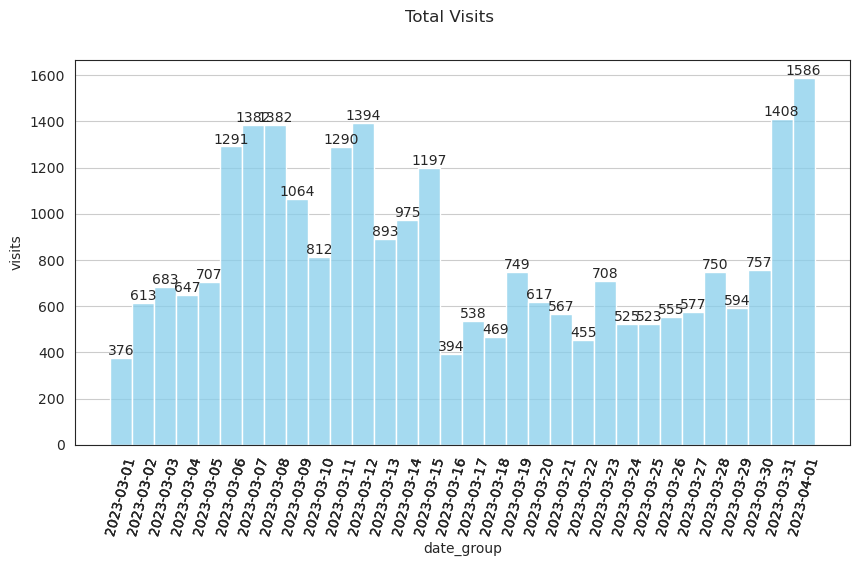

<Figure size 640x480 with 0 Axes>

In [187]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Total Visits")
ax.grid(axis='y')
sns.set_style("white")
ax = sns.histplot(x="datetime", data=visitors, color='skyblue')
ax.set_xticks(grouped_visitors['datetime'])
plt.xticks(rotation = 75)
plt.xlabel('date_group')
plt.ylabel('visits')
ax.bar_label(ax.containers[0])
plt.show()
plt.savefig('./charts/total_visits.png')

In [189]:
### Итоговые визиты с разбивкой по платформе

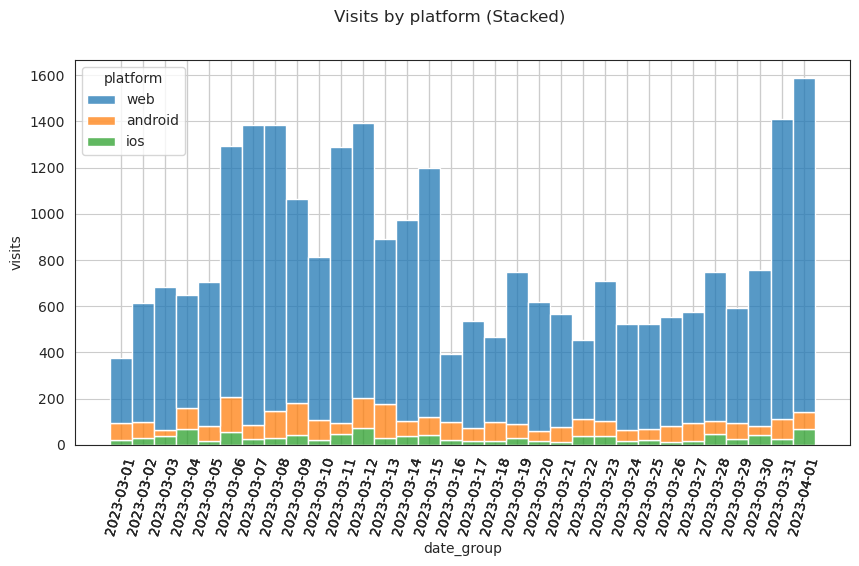

<Figure size 640x480 with 0 Axes>

In [191]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Visits by platform (Stacked)")
ax.grid()
ax = sns.histplot(data=visitors, x="datetime", hue='platform', multiple='stack')
ax.set_xticks(grouped_visitors['datetime'])
plt.xlabel('date_group')
plt.ylabel('visits')
plt.xticks(rotation = 75)
plt.show()
plt.savefig('./charts/visitors_by_platform.png')

In [192]:
### Итоговые регистрации

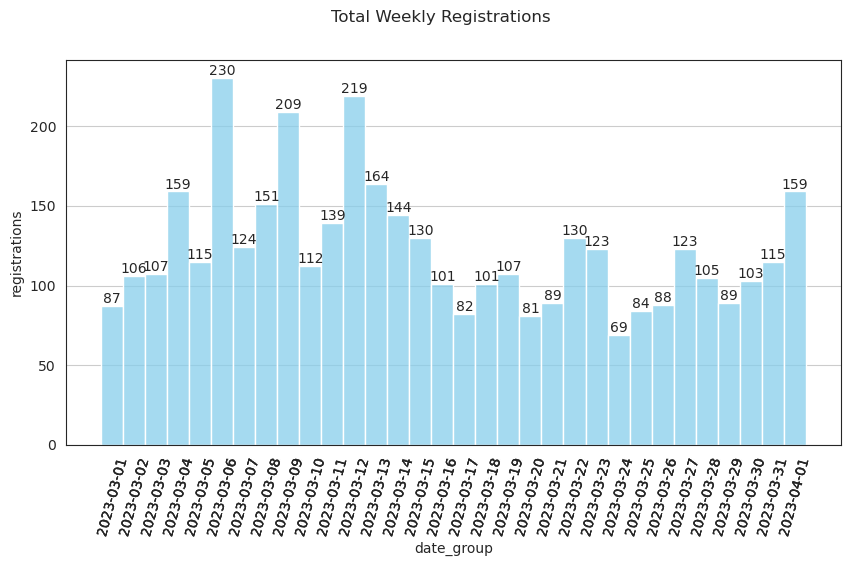

<Figure size 640x480 with 0 Axes>

In [193]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Total Weekly Registrations")
ax.grid(axis='y')
sns.set_style("white")
ax = sns.histplot(x="datetime", data=regs, color='skyblue')
ax.set_xticks(grouped_regs['datetime'])
plt.xticks(rotation = 75)
plt.xlabel('date_group')
plt.ylabel('registrations')
ax.bar_label(ax.containers[0])
plt.show()
plt.savefig('./charts/total_regs.png')

In [197]:
### Итоговые регистрации с разбивкой по платформе

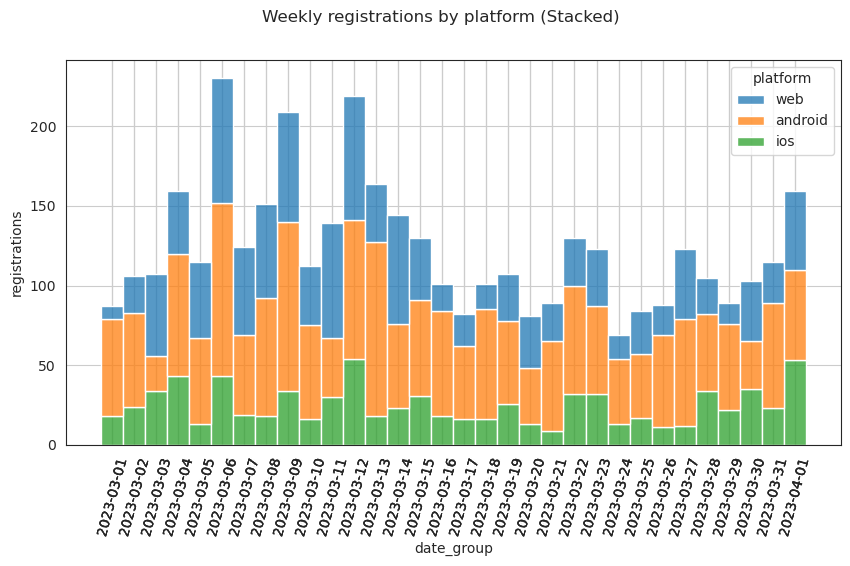

<Figure size 640x480 with 0 Axes>

In [199]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Weekly registrations by platform (Stacked)")
ax.grid()
ax = sns.histplot(data=regs, x="datetime", hue='platform', multiple='stack')
ax.set_xticks(grouped_regs['datetime'])
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.xticks(rotation = 75)
plt.show()
plt.savefig('./charts/registrations_by_platform.png')

In [201]:
### Итоговые конверсии

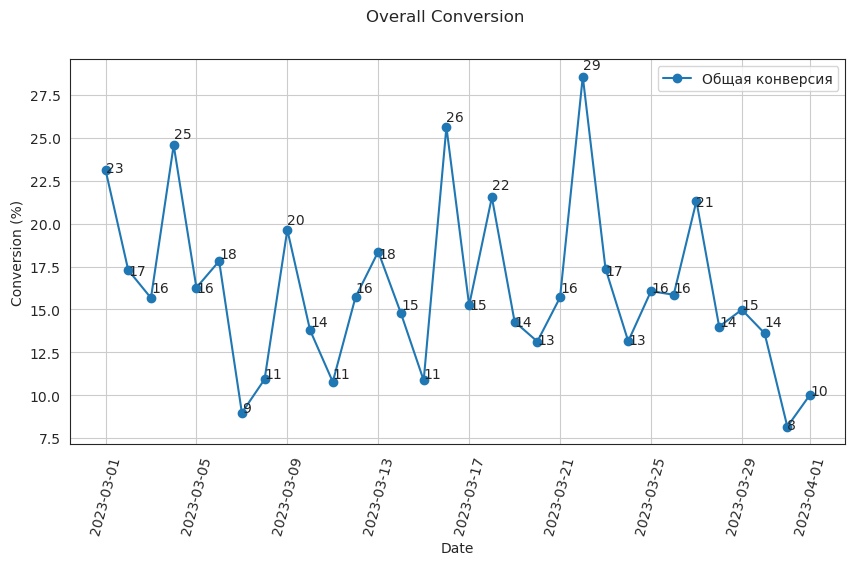

<Figure size 640x480 with 0 Axes>

In [207]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Overall Conversion")
ax.grid()
x = total_conversion['date_group']
y = total_conversion['conversion']
ax.plot('date_group', 'conversion', data=total_conversion, marker='o', label='Общая конверсия')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(rotation = 75)
plt.legend()
for (xi, yi) in zip(x, y):
    plt.text(xi, round(yi), round(yi))
plt.show()
plt.savefig('./charts/total_conversion.png')

In [ ]:
### Конверсии по каждой платформе

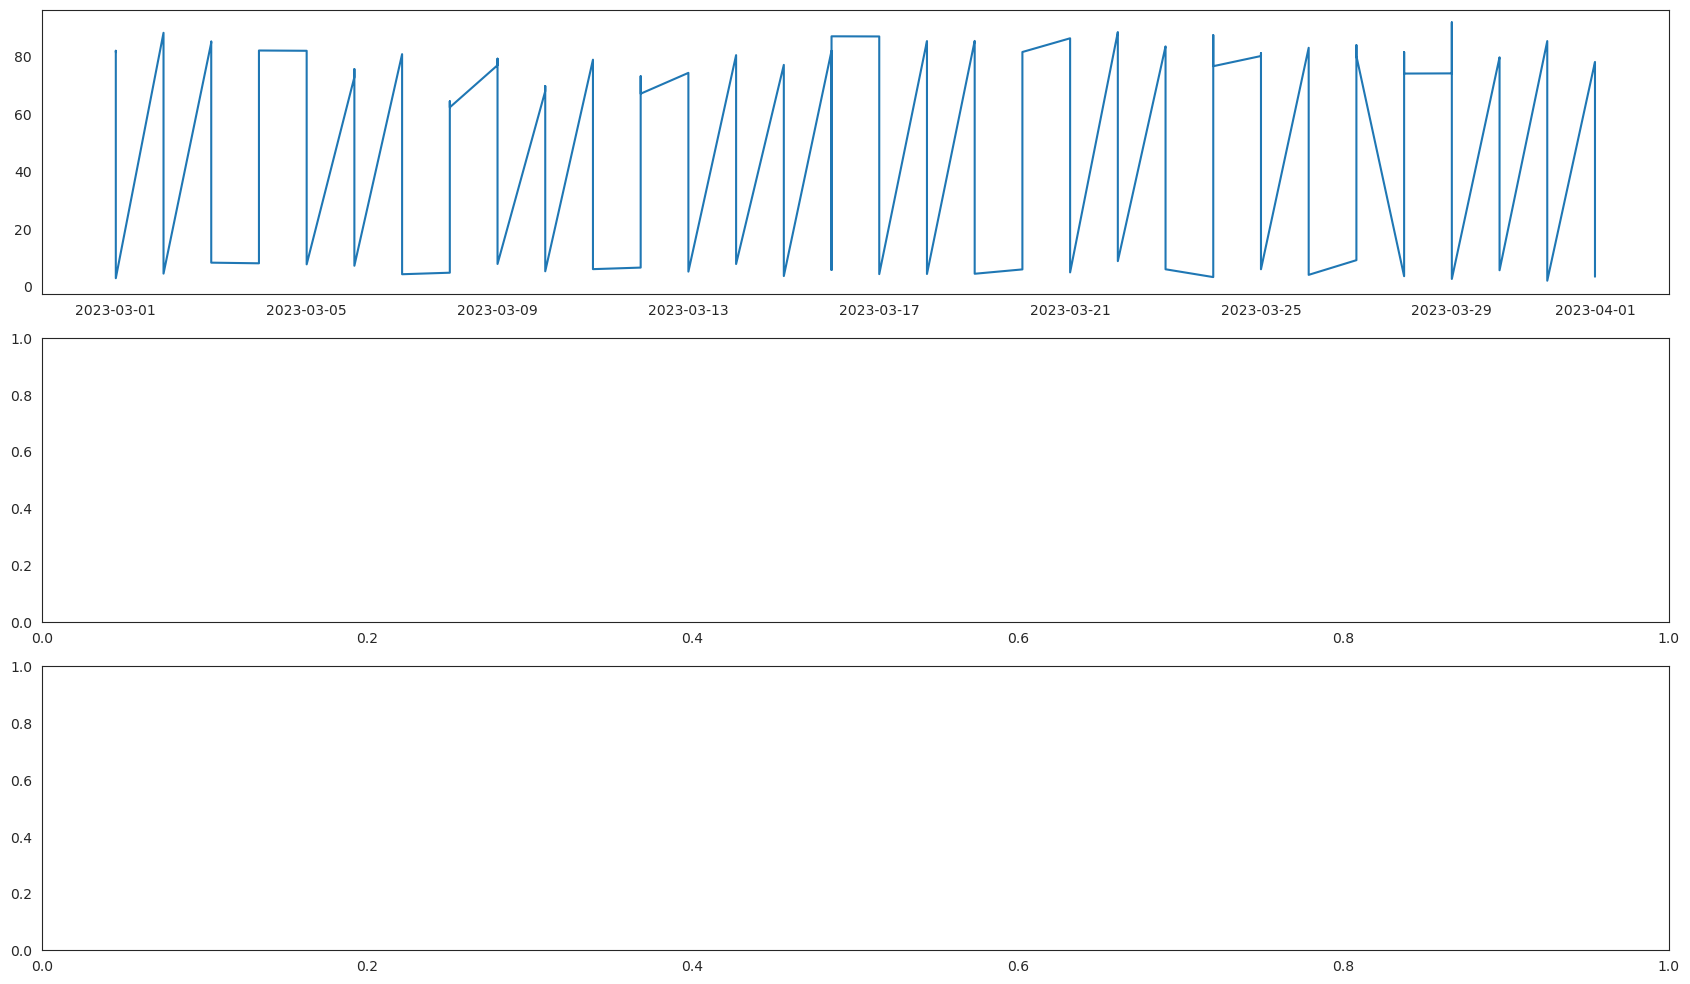

<Figure size 640x480 with 0 Axes>

In [281]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((17, 10))
plt.tight_layout()

x = conversion['date_group']
y = conversion['conversion']
ax[0].plot(x, y, data=conversion[conversion['platform'] == 'android'])

# for n in range(3):
    # feature_name = conversion.feauture_names[n]
    # ax_position = ax[n // 15, n % 3]
    # ax_position.plot('date_group', 'conversion', data=conversion)
    # ax_position.legend()
    # ax_position.grid()
    

# x = conversion['date_group']
# y = conversion['conversion']
# ax[0][1].plot('date_group', 'conversion', data=total_conversion, marker='o', label='Общая конверсия')
# # ax.set_xticks(grouped_regs['datetime'])
# plt.xlabel('Date')
# plt.ylabel('Conversion (%)')
# plt.xticks(rotation = 75)
# plt.legend()
# for (xi, yi) in zip(x, y):
#     plt.text(xi, round(yi), round(yi))
plt.show()
plt.savefig('./charts/conversion_by_platform.png')